# Modelo de Clasificación DBSCAN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import boto3

# Configuración de S3
bucket_name = 'rawmattelsa'
folder_name = 'Fotos/'


# Función para cargar y preprocesar imágenes desde S3
def cargar_y_preprocesar_imagen_s3(ruta_completa):
    try:
        response = s3.get_object(Bucket=bucket_name, Key=ruta_completa)
        imagen_bytes = response['Body'].read()

        # Procesar la imagen
        imagen = tf.image.decode_image(imagen_bytes, channels=1)  # Convertir a escala de grises
        imagen = tf.image.resize(imagen, [64, 64])  # Ajustar tamaño
        imagen = tf.keras.utils.img_to_array(imagen)
        imagen = imagen / 255.0  # Normalizar
        return imagen
    except Exception as e:
        print(f"Error al cargar la imagen {ruta_completa}: {e}")
        return None

# Función para generar DataFrame con rutas de S3
def generar_dataframe_s3(bucket_name, folder_name):
    try:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)
        if 'Contents' in response:
            rutas = []
            nombres = []
            for obj in response['Contents']:
                ruta_completa = obj['Key']
                if ruta_completa.endswith('/'):
                    continue
                rutas.append(ruta_completa)
                nombres.append(ruta_completa.split('/')[-1])
            df = pd.DataFrame({'ruta': rutas, 'nombre': nombres})
            print("DataFrame generado con rutas:")
            print(df.head())
            return df
    except Exception as e:
        print(f"Error al generar el DataFrame desde S3: {e}")
        return None

# Generar DataFrame desde S3
df = generar_dataframe_s3(bucket_name, folder_name)

# Dividir en entrenamiento y prueba
X = df['ruta']
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Cargar las imágenes de entrenamiento
X_train_arrays = np.array([cargar_y_preprocesar_imagen_s3(ruta) for ruta in X_train if cargar_y_preprocesar_imagen_s3(ruta) is not None])

# 1. Modelo Autoencoder
input_shape = (64, 64, 1)  # Tamaño de las imágenes preprocesadas

# Definir la arquitectura del autoencoder
input_layer = layers.Input(shape=input_shape)
encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)

decoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

# Modelo completo
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compilación
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 2. Entrenamiento del Autoencoder
epochs = 20
batch_size = 16

autoencoder.fit(X_train_arrays, X_train_arrays, epochs=epochs, batch_size=batch_size, verbose=1)

# 3. Extraer representaciones latentes
encoder = Model(inputs=input_layer, outputs=encoded)  # Modelo para las representaciones latentes
representaciones_latentes = encoder.predict(X_train_arrays)
representaciones_latentes = representaciones_latentes.reshape(representaciones_latentes.shape[0], -1)  # Aplanar para clustering

# 4. Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(representaciones_latentes)

# 5. Filtrar ruido y mostrar resultados
datos_filtrados = X_train_arrays[labels != -1]
labels_filtrados = labels[labels != -1]

print(f"Total de clusters encontrados (excluyendo ruido): {len(set(labels_filtrados)) - 1}")
print(f"Cantidad de puntos de ruido detectados: {np.sum(labels == -1)}")



DataFrame generado con rutas:
                                ruta                 nombre
0  Fotos/FOTOS/IG-Jul-S2-2022-03.jpg  IG-Jul-S2-2022-03.jpg
1  Fotos/FOTOS/IG-Jul-S2-2022-04.jpg  IG-Jul-S2-2022-04.jpg
2  Fotos/FOTOS/IG-Jul-S2-2022-05.jpg  IG-Jul-S2-2022-05.jpg
3  Fotos/FOTOS/IG-Jul-S2-2022-06.jpg  IG-Jul-S2-2022-06.jpg
4  Fotos/FOTOS/IG-Jul-S2-2022-07.jpg  IG-Jul-S2-2022-07.jpg
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 0.0786
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - loss: 0.0289
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - loss: 0.0230
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 0.0213
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - loss: 0.0206
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0201
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - loss: 0.0195
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 0.0185
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.0174

In [ ]:
print("Etiquetas asignadas por DBSCAN:", labels)

Etiquetas asignadas por DBSCAN: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 

In [ ]:
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Cantidad de clusters encontrados (excluyendo ruido): {num_clusters}")

Cantidad de clusters encontrados (excluyendo ruido): 0


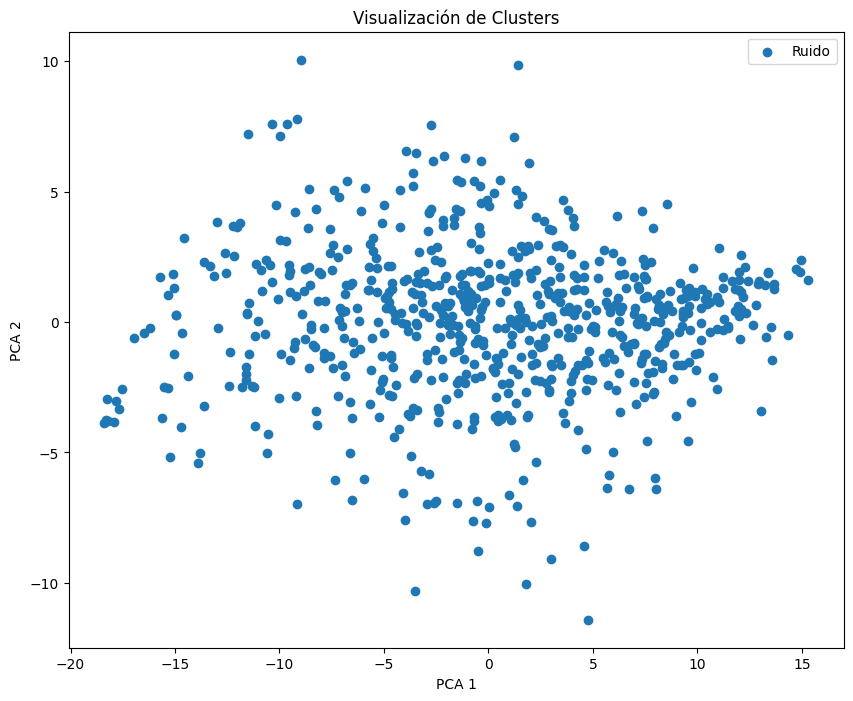

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir dimensiones a 2D para graficar
pca = PCA(n_components=2)
representaciones_2d = pca.fit_transform(representaciones_latentes)

# Crear gráfico
plt.figure(figsize=(10, 8))
for cluster_id in set(labels):
    puntos_cluster = representaciones_2d[labels == cluster_id]
    plt.scatter(puntos_cluster[:, 0], puntos_cluster[:, 1], label=f'Cluster {cluster_id}' if cluster_id != -1 else 'Ruido')

plt.title("Visualización de Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()

In [ ]:
# Filtrar imágenes por cluster
cluster_id = 0  # Cambiar al cluster que quieras inspeccionar
indices_cluster = np.where(labels == cluster_id)[0]

print(f"Imágenes en el Cluster {cluster_id}:")
for idx in indices_cluster[:5]:  # Mostrar solo las primeras 5
    imagen = X_train_arrays[idx]  # Cargar imagen preprocesada
    plt.imshow(imagen.squeeze(), cmap='gray')
    plt.title(f"Cluster {cluster_id}")
    plt.axis('off')
    plt.show()

Imágenes en el Cluster 0:
